# FAST-UAV - Multirotor Design Optimization

[FAST-OAD](https://fast-oad.readthedocs.io) is a framework for performing rapid Overall Aircraft Design. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/). <br>
FAST-UAV is the drone declination of FAST-OAD.

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [DJI Matrice 600 Pro](https://www.dji.com/matrice600-pro) multicopter. In `workdir/`, we store files generated or modified by FAST-UAV.

In [27]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
from fastuav.utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_inputs_DJI_M600.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [28]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo.yaml"
)

INFO    : Sample configuration written in "D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\multirotor_mdo.yaml".


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo.yaml'

The YAML configuration file located in the data folder defines the design problem, i.e. the model, the problem driver and the optimization problem definition.<br>
A useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [29]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


In the configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-UAV to generate the inputs of the model with the reference parameters from 'problem_inputs_DJI_M600.xml' as default values:

In [30]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

You can now checkout the generated [input file](./workdir/problem_inputs.xml). The values in this file can be modified by the user and will be considered by FAST-UAV when executing a computational process.<br>
The `variable-viewer` provides a way to inspect and modify the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [31]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Running an MDO

You can now run an optimization problem. The last part of the configuration file .yaml is where this optimization problem is defined:

```yaml
optimization:
  design_variables:
    - name: data:weights:mtow:k # over estimation coefficient on the load mass
      upper: 40.0
      lower: 1.0
  constraints:
    - name: data:weights:mtow:guess:constraint # mass consistency
      lower: 0.0
  objective:
    - name: data:weights:mtow
      scaler: 1e-1
```

In [32]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [-0.03316797]
            Iterations: 55
            Function evaluations: 101
            Gradient evaluations: 54
Optimization Complete
-----------------------------------


INFO    : Computation finished after 4.11 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


Let's save these results:

In [33]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, 'problem_outputs_DJI_M600_mdo.xml')
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)

'../data\\problem_outputs_DJI_M600_mdo.xml'

The `optimizer_viewer` offers a convenient summary of the optimization result. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated.

In [34]:
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [35]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

You can now use postprocessing plots to visualize the results of the MDO.

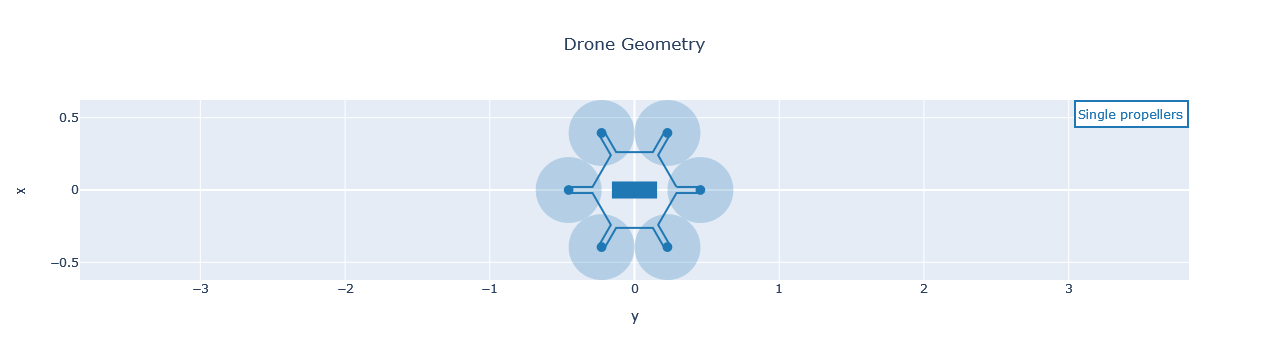

In [36]:
fig = multirotor_geometry_plot(DJI_M600_OUTPUT_FILE, name="Drone MDO")
fig.show()

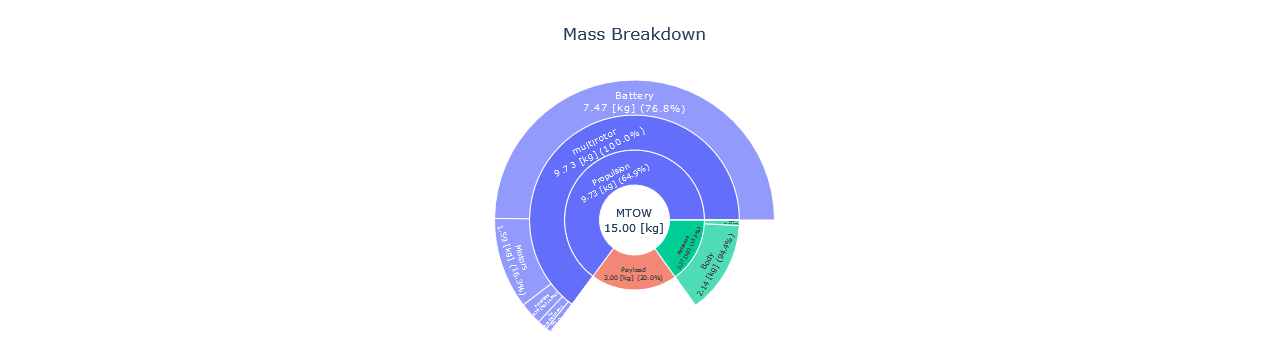

In [37]:
fig = mass_breakdown_sun_plot_drone(DJI_M600_OUTPUT_FILE)
fig.show()